## HTX xData Test cv-train-2a Python Notebook

Install some dependencies that are required for project

In [7]:
%pip install datasets --upgrade
%pip install transformers --upgrade
%pip install jiwer
%pip install transformers[torch]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Load the Common Voice csv file and explore the data

In [9]:
import pandas as pd
import os

CV_DIRECTORY = "/home/zchin/common_voice/"

cv_metadata = pd.read_csv(os.path.join(CV_DIRECTORY, 'cv-valid-train.csv'))

cv_metadata.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


In [10]:
cv_meta_sample = cv_metadata
# cv_meta_sample = cv_metadata.sort_values(by=['down_votes', 'up_votes'], ascending = [True, False]).head(20000)

cv_meta_sample.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


Load the cv-valid-train data into a dataset object (Drop metadata as we will manually add relevant columns)

In [11]:
import os
from datasets import Dataset, load_dataset, Audio

data_files = [os.path.join(CV_DIRECTORY, "cv-valid-train", filename) for filename in cv_meta_sample["filename"]]

cv_dataset = load_dataset("audiofolder", data_files=data_files, drop_metadata=True)

cv_dataset = cv_dataset["train"]

print(cv_dataset)

Dataset({
    features: ['audio'],
    num_rows: 195776
})


Add relevant columns to the dataset for labelling and cleaning at later stage

In [12]:
cv_dataset = cv_dataset.add_column("file", cv_meta_sample["filename"])
cv_dataset = cv_dataset.add_column("text", cv_meta_sample["text"])
cv_dataset = cv_dataset.add_column("up_votes", cv_meta_sample["up_votes"])
cv_dataset = cv_dataset.add_column("down_votes", cv_meta_sample["down_votes"])

print(cv_dataset)
print("File:        {}".format(cv_dataset[0]["file"]))
print("Audio:       {}".format(cv_dataset[0]["audio"]))
print("Text:        {}".format(cv_dataset[0]["text"]))
print("Upvotes:     {}".format(cv_dataset[0]["up_votes"]))
print("Downvotes:   {}".format(cv_dataset[0]["down_votes"]))

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 195776
})
File:        cv-valid-train/sample-000000.mp3
Audio:       {'path': '/home/zchin/common_voice/cv-valid-train/cv-valid-train/sample-000000.mp3', 'array': array([ 0.00000000e+00, -2.39675413e-13, -2.89491331e-14, ...,
        4.10622597e-04,  7.94679159e-04,  7.57522532e-04]), 'sampling_rate': 48000}
Text:        learn to recognize omens and follow them the old king had said
Upvotes:     1
Downvotes:   0


Get the duration of each sample into a dictionary

In [13]:
duration_dict = {}

def duration_histogram(batch):
    duration = len(batch["audio"]["array"]) // batch["audio"]["sampling_rate"]
    duration_dict[duration] = duration_dict.get(duration, 0) + 1

cv_dataset.map(duration_histogram)

Map: 100%|██████████| 195776/195776 [07:08<00:00, 457.10 examples/s]


Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 195776
})

Due to memory constraints during training and evaluation, longer audio tracks need to be dropped. Here, we get the max duration and cumulative sum of audio tracks for each duration in seconds. We try to keep at least 80% of the samples.

In [14]:
max_duration = max(duration_dict.keys())
histogram = [0] * max_duration
cumsum = [0] * max_duration

for duration, num_samples in duration_dict.items():
    histogram[duration - 1] = num_samples

subtotal = 0
for i in range(len(histogram)):
    subtotal += histogram[i]
    cumsum[i] = subtotal

for i in range(len(cumsum)):
    cumsum[i] /= len(cv_dataset)

for duration, fraction in enumerate(cumsum):
    if fraction >= 0.8:
        cutoff_duration = duration + 1
        break

print("Max duration: {}".format(max_duration))
print(histogram)
print(cumsum)
print("Cutoff duration: {}".format(cutoff_duration))

Max duration: 393
[6625, 36892, 49435, 40682, 28937, 16985, 8078, 3694, 1920, 988, 552, 314, 153, 110, 96, 46, 40, 32, 21, 19, 19, 14, 10, 10, 5, 5, 7, 6, 1, 6, 1, 3, 1, 1, 2, 3, 0, 3, 1, 1, 0, 2, 2, 0, 2, 2, 0, 2, 2, 3, 0, 0, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Data samples with number of downvotes more than 10% of number of upvotes, 0 upvotes or duration longer than cutoff are filtered out to remove poor quality samples.

In [15]:
cv_clean_dataset = cv_dataset.filter(lambda batch: (0.1 * batch["up_votes"] > batch["down_votes"]) and 
                                                    batch["up_votes"] >= 1 and 
                                                    (len(batch["audio"]["array"]) // batch["audio"]["sampling_rate"]) <= cutoff_duration)

Split the dataset into train and test datasets

In [16]:
cv_ds_dict = cv_clean_dataset.train_test_split(test_size=0.3)

print(cv_ds_dict)
print(cv_ds_dict["train"][0])
print(cv_ds_dict["test"][0])

DatasetDict({
    train: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 103547
    })
    test: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 44378
    })
})
{'audio': {'path': '/home/zchin/common_voice/cv-valid-train/cv-valid-train/sample-186262.mp3', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -2.74219190e-07, -1.06442769e-07, -3.60982540e-07]), 'sampling_rate': 48000}, 'file': 'cv-valid-train/sample-186262.mp3', 'text': 'there were just drawings coded instructions and obscure texts', 'up_votes': 2, 'down_votes': 0}
{'audio': {'path': '/home/zchin/common_voice/cv-valid-train/cv-valid-train/sample-016102.mp3', 'array': array([0., 0., 0., ..., 0., 0., 0.]), 'sampling_rate': 48000}, 'file': 'cv-valid-train/sample-016102.mp3', 'text': 'with her index finger the little girl pointed to her mum', 'up_votes': 1, 'down_votes': 0}


Browse through the dataset to check for any issues

In [17]:
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

print("Total number of samples: {}".format(sum(cv_ds_dict.num_rows.values())))
show_random_elements(cv_ds_dict["train"].remove_columns([f for f in cv_ds_dict["train"].features if f != "text"]))

Total number of samples: 147925


,text
0,is there a mrs joshua
1,please bring mama back
2,the whole army of them
3,then came the night of the first falling star
4,they provided warnings about thieves and barbarian tribes
5,we lit the lantern and walked over to his house
6,revenge is not my style but obviously accidents will happen
7,you'd think i committed some sort of crime
8,some of them had binoculars
9,you wanna take this outside


Remove any special characters that are not recognized by the tokenizer, as well as capitalize the characters for the tokenizer to recognize

In [18]:
import re
chars_to_ignore_regex = r'[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).upper()
    return batch

cv_ds_dict = cv_ds_dict.map(remove_special_characters)

Map: 100%|██████████| 44378/44378 [00:02<00:00, 17028.93 examples/s]


In [19]:
show_random_elements(cv_ds_dict["train"].remove_columns([f for f in cv_ds_dict["train"].features if f != "text"]))

,text
0,IT'S NO MIRACLE BECAUSE I SEE IT HAPPEN ONCE EVERY YEAR
1,THERE MUST BE SOMEBODY THERE
2,I UNDERSTAND SHEEP THEY'RE NO LONGER A PROBLEM AND THEY CAN BE GOOD FRIENDS
3,NO THE ALCHEMIST ANSWERED
4,JUNE DECIDED TO RETIRE
5,I WENT STRETCHING MY LEGS CLUMSILY AND FEELING MY WAY IN THE DARK
6,LISTEN TO YOUR HEART
7,YOU SHOULD SEE HIS FAN MAIL
8,THE TOWNSFOLK WERE ALL CHUMPS
9,SO WHAT IS SALEM LIKE HE ASKED TRYING TO GET SOME SORT OF CLUE


We use the facebook/wav2vec2-large-960h Wav2Vec2Processor for our audio/label processing. This processor is trained on the librispeech dataset, a corpus of approximately 1000 hours of 16Khz read English speech derived from read audiobooks from the LibriVox project. 

Our training dataset Common Voice is created by volunteers who record sample sentences with a microphone and review recordings of other users. 

Due to the similarity in both datasets, where a single speaker narrates into a microphone, we can use the pretrained processor for our use. The processor also normalizes the inputs, so no extra normalization step is required.

In [20]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

SAMPLING_RATE = processor.feature_extractor.sampling_rate

cv_ds_clean_dict = cv_ds_dict.cast_column("audio", Audio(sampling_rate=SAMPLING_RATE))

print(cv_ds_clean_dict)
print(cv_ds_clean_dict["train"][0]["audio"])

DatasetDict({
    train: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 103547
    })
    test: Dataset({
        features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
        num_rows: 44378
    })
})
{'path': '/home/zchin/common_voice/cv-valid-train/cv-valid-train/sample-186262.mp3', 'array': array([ 5.68434189e-14,  7.10542736e-14, -5.11590770e-13, ...,
       -3.41047439e-07,  2.37861983e-07, -2.48506865e-07]), 'sampling_rate': 16000}


Explore the data to ensure that the target text matches the audio output

In [21]:
import IPython.display as ipd
import numpy as np
import random

data_split = ["train", "test"]

rand_split = random.choice(data_split)
rand_int = random.randint(0, len(cv_ds_clean_dict[rand_split]))

print("Data split:          {}".format(rand_split))
print("File:                {}".format(cv_ds_clean_dict[rand_split][rand_int]["file"]))
print("Audio:               {}".format(cv_ds_clean_dict[rand_split][rand_int]["audio"]))
print("Target Text:         {}".format(cv_ds_clean_dict[rand_split][rand_int]["text"]))
print("Input array shape:   {}".format(np.asarray(cv_ds_clean_dict[rand_split][rand_int]["audio"]["array"]).shape))
print("Sampling rate:       {}".format(cv_ds_clean_dict[rand_split][rand_int]["audio"]["sampling_rate"]))
ipd.Audio(data=np.asarray(cv_ds_clean_dict[rand_split][rand_int]["audio"]["array"]), autoplay=True, rate=SAMPLING_RATE)

Data split:          test
File:                cv-valid-train/sample-105015.mp3
Audio:               {'path': '/home/zchin/common_voice/cv-valid-train/cv-valid-train/sample-105015.mp3', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -4.72708416e-06,  1.12684347e-07,  8.40309440e-06]), 'sampling_rate': 16000}
Target Text:         STRANGE IMAGES PASSED THROUGH MY MIND
Input array shape:   (52992,)
Sampling rate:       16000


Prepare the dataset to train the model by processing the audio and text into input values and labels

In [22]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio=audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["labels"] = processor(text=batch["text"]).input_ids

    return batch

cv_ds_clean_dict = cv_ds_clean_dict.map(prepare_dataset, remove_columns=cv_ds_clean_dict.column_names["train"])
print(cv_ds_clean_dict)

Map: 100%|██████████| 44378/44378 [02:31<00:00, 292.03 examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 103547
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 44378
    })
})


Collator dataclass to pad the input values and labels so that the data can be of uniform size when they are passed into the model.

In [23]:
import torch

from dataclasses import dataclass
from typing import Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

Add WER metric to provide an idea of how the model is doing during training/evaluation.

In [24]:
from datasets import load_metric

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
wer_metric = load_metric("wer")

/tmp/ipykernel_114935/2444964255.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")
/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/datasets/load.py:753: FutureWarning: The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.0/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [25]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [26]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

model.freeze_feature_extractor()

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You s

We set the batch size to 32 (8 batch size * 4 gradient accumulation steps) and the learning rate to 1e-4. 1e-4 is the original learning rate for the pretrained model, and the batch size is commonly used as it is large enough to train the model to generalize without learning noise in a smaller batch. bf16 is a format developed for machine learning purposes due to its larger dynamic range (at the expense of lower precision), which aids in preserving gradient information during training for convergence.

In [27]:
from transformers import TrainingArguments

REPO_NAME = "/home/zchin/htx_xdata_test/asr-train/models"

training_args = TrainingArguments(
  output_dir=REPO_NAME,
  group_by_length=True,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  gradient_accumulation_steps=4,  # increase by 2x for every 2x decrease in batch size
  eval_accumulation_steps=4,
  evaluation_strategy="steps",
  num_train_epochs=5,
  bf16=True,
  gradient_checkpointing=True, 
  save_steps=1000,
  eval_steps=1000,
  logging_steps=250,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=100,
  save_total_limit=2,
  push_to_hub=False,
)

training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=True,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=4,
eval_delay=0,
eval_steps=1000,
evaluation_strategy=IntervalStrategy.STEPS,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=4,
gradient_checkpointing=True,
gradient_checkpointing_kwargs=None,
greater_is_better=Non

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=cv_ds_clean_dict["train"],
    eval_dataset=cv_ds_clean_dict["test"],
    tokenizer=processor.feature_extractor,
)

In [29]:
trainer.train()

/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
1000,138.679800,74.537651,0.119564
2000,119.898800,69.185387,0.100862
3000,113.458700,57.565376,0.088464
4000,98.428900,53.955147,0.079460
5000,94.438000,49.594139,0.070853
6000,84.073100,45.006100,0.066865
7000,73.494700,42.191227,0.060618
8000,71.162400,38.355186,0.054612
9000,67.298600,33.003452,0.050600
10000,54.012600,32.238758,0.047056


/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/transformers/models/wav2vec2/processing_wav

TrainOutput(global_step=16180, training_loss=76.09050407645434, metrics={'train_runtime': 36223.0254, 'train_samples_per_second': 14.293, 'train_steps_per_second': 0.447, 'total_flos': 5.9323398496507036e+19, 'train_loss': 76.09050407645434, 'epoch': 5.0})

In [30]:
loss_df = pd.DataFrame(trainer.state.log_history)
trainloss_df = loss_df.dropna(axis=0, subset="loss")
evalloss_df = loss_df.dropna(axis=0, subset="eval_loss")

In [31]:
trainloss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,161.6397,0.000099,0.08,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,145.8979,0.000098,0.15,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,143.8014,0.000096,0.23,750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,138.6798,0.000094,0.31,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,139.0416,0.000093,0.39,1250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,37.7713,0.000007,4.64,15000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,36.9922,0.000006,4.71,15250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,38.3880,0.000004,4.79,15500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,37.2355,0.000003,4.87,15750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
evalloss_df

,loss,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
4,NaN,NaN,0.31,1000,74.537651,0.119564,1199.6028,36.994,4.625,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.62,2000,69.185387,0.100862,1206.8685,36.771,4.597,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,0.93,3000,57.565376,0.088464,1206.6811,36.777,4.598,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,1.24,4000,53.955147,0.079460,1219.4447,36.392,4.550,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,1.55,5000,49.594139,0.070853,1216.5308,36.479,4.561,NaN,NaN,NaN,NaN,NaN
29,NaN,NaN,1.85,6000,45.006100,0.066865,1224.3987,36.245,4.531,NaN,NaN,NaN,NaN,NaN
34,NaN,NaN,2.16,7000,42.191227,0.060618,1218.9172,36.408,4.552,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,2.47,8000,38.355186,0.054612,1216.4982,36.480,4.561,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,2.78,9000,33.003452,0.050600,1218.4909,36.420,4.553,NaN,NaN,NaN,NaN,NaN
49,NaN,NaN,3.09,10000,32.238758,0.047056,1217.6073,36.447,4.556,NaN,NaN,NaN,NaN,NaN


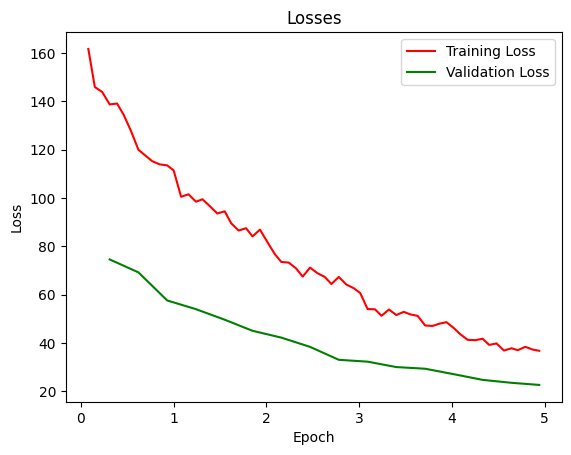

In [36]:
import matplotlib.pyplot as plt

plt.plot(trainloss_df["epoch"], trainloss_df["loss"], color='r', label='Training Loss')
plt.plot(evalloss_df["epoch"], evalloss_df["eval_loss"], color='g', label='Validation Loss')

# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.title("Losses") 

# Adding legend, which helps us recognize the curve according to its color 
plt.legend() 

plt.show()

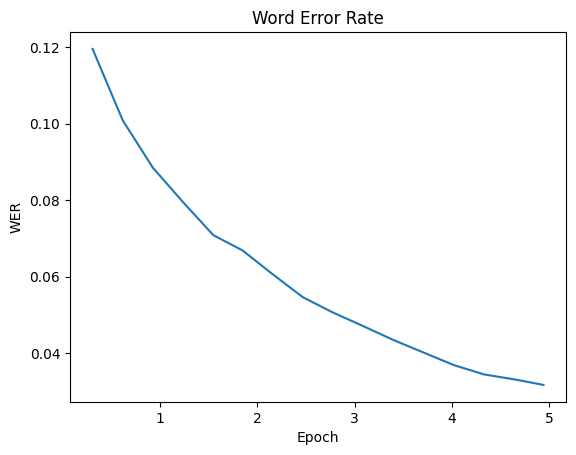

In [37]:
plt.plot(evalloss_df["epoch"], evalloss_df["eval_wer"])

# Naming the x-axis, y-axis and the whole graph 
plt.xlabel("Epoch") 
plt.ylabel("WER") 
plt.title("Word Error Rate")

plt.show()

In [40]:
trainer.save_model("wav2vec2-large-960h-cv")

In [42]:
cv_eval_metadata = pd.read_csv(os.path.join(CV_DIRECTORY, 'cv-valid-test.csv'))

cv_eval_metadata.head(5)

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of pe...,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disablin...,2,0,NaN,NaN,NaN,NaN


In [44]:
from datasets import load_dataset

data_files = [os.path.join(CV_DIRECTORY, "cv-valid-test", filename) for filename in cv_eval_metadata["filename"]]

cv_eval_dataset = load_dataset("audiofolder", data_files=data_files, drop_metadata=True)

cv_eval_dataset = cv_eval_dataset["train"]

cv_eval_dataset = cv_eval_dataset.add_column("file", cv_eval_metadata["filename"])
cv_eval_dataset = cv_eval_dataset.add_column("text", cv_eval_metadata["text"])
cv_eval_dataset = cv_eval_dataset.add_column("up_votes", cv_eval_metadata["up_votes"])
cv_eval_dataset = cv_eval_dataset.add_column("down_votes", cv_eval_metadata["down_votes"])

print(cv_eval_dataset)
print("File:        {}".format(cv_eval_dataset[0]["file"]))
print("Audio Path:  {}".format(cv_eval_dataset[0]["audio"]))
print("Text:        {}".format(cv_eval_dataset[0]["text"]))
print("Upvotes:     {}".format(cv_eval_dataset[0]["up_votes"]))
print("Downvotes:   {}".format(cv_eval_dataset[0]["down_votes"]))

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes'],
    num_rows: 3995
})
File:        cv-valid-test/sample-000000.mp3
Audio Path:  {'path': '/home/zchin/common_voice/cv-valid-test/cv-valid-test/sample-000000.mp3', 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       4.82659198e-06, 5.34801120e-06, 1.52398775e-06]), 'sampling_rate': 48000}
Text:        without the dataset the article is useless
Upvotes:     1
Downvotes:   0


In [45]:
cv_eval_ds = cv_eval_dataset.map(remove_special_characters)
cv_eval_ds = cv_eval_ds.cast_column("audio", Audio(sampling_rate=SAMPLING_RATE))

eval_prepared_ds = cv_eval_ds.map(prepare_dataset)

print(eval_prepared_ds)

Map: 100%|██████████| 3995/3995 [02:19<00:00, 28.68 examples/s] 

Dataset({
    features: ['audio', 'file', 'text', 'up_votes', 'down_votes', 'input_values', 'labels'],
    num_rows: 3995
})


In [46]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device=device).unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

results = eval_prepared_ds.map(map_to_result)

Parameter 'function'=<function map_to_result at 0x7f289bdda700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   0%|          | 0/3995 [00:00<?, ? examples/s]/home/zchin/miniconda3/envs/htx_xdata_test/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more det

In [47]:
show_random_elements(results.remove_columns([f for f in results.features if f not in ["pred_str", "text"]]))

print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

,text,pred_str
0,EVERYTHING HAS BEEN WRITTEN BY THE SAME HAND,EVERYTHING HAD BEEN WRITTEN BY THE SANG HAND
1,THEY SET OFF RUNNING WILDLY INTO THE TREES,THEY SET OFF RUNNING WILDLY INTO THE TRAY
2,AFTER THE DICTATOR'S RULE OF FOURTY THREE YEARS WAS OVER THE COUNTRY WAS DEVASTATED,AFTER THE DICTATOR R OF FORTY TH YEARS WAS OVER THE COUNTRY WAS TEVESTET
3,BUT INSTEAD OF BEING SADDENED HE WAS HAPPY,BUT INSTEAD OF BEING SADDENED HE WAS HAPPY
4,HE MUST BE DISGUISED TO AVOID ENCOUNTERS WITH THIEVES,HE MUST BE DISGUISED TO AVOID ENCOUNTERS WITH THIEVES
5,THE BOSS SENT ME OVER WITH IT,THE BOSS SENT ME OVER WITH IT
6,IT'S EXTREMELY SUSPICIOUS THAT THERE'S NO INFORMATION ABOUT BRAINS THAT DIDN'T COME FROM A BRAIN,IT'S EXTREMELY SUSPICIOUS THAT THERE'S NO INFORMATION ABOUT BRAINS THAT DIDN'T COME FROM A BRAIN
7,IT'S LIKE THE FLIGHT OF THOSE TWO HAWKS IT CAN'T BE UNDERSTOOD BY REASON ALONE,IT'S LIKE THE FLIGHT OF THOSE TWO HAWKS IT CAN'T BE UNDERSTOOD BY REASON ALONE
8,LOOKING AROUND HE SOUGHT HIS SHEEP AND THEN REALIZED THAT HE WAS IN A NEW WORLD,LOOKING AROUND HE SOUGHT HIS SHEEP AND THEN REALIZED THAT HE WAS IN A NEW WORLD
9,THE HEAT LASTED UNTIL NIGHTFALL AND ALL THAT TIME HE HAD TO CARRY HIS JACKET,THE HEAT LASTED UNTIL NIGHTFALL AND ALL THAT TIME HE HAD TO BARY HIS JACKET


Test WER: 0.094


In [48]:
cv_eval_metadata["generated_text"] = results["pred_str"]
cv_eval_metadata.to_csv("cv-valid-test.csv", index=False)